# 4G10 Coursework 2: predicting hand kinematics from neural data


Please read carefully the last section of this notebook, which gives some of our expectations regarding your report.

In this handout, 
- <u>text that is underlined</u> corresponds to things you have to do / implement.
- **text in bold** corresponds to questions you need to answer in some form in your report.


In [215]:
from io import BytesIO

import numpy
import timeit
import numpy as np
import matplotlib.pyplot as plt
import requests
import scipy
from scipy.ndimage import gaussian_filter
from scipy.linalg import inv

import seaborn as sns
sns.set(rc={'figure.figsize': (14, 8.27)}, font_scale=2)
sns.set_palette('colorblind')

# 1. Setup

In this piece of 4G10 coursework, you will use neural data recorded in the primary motor cortex (M1) of a reaching monkey to predict the kinematics of the monkey's hand.

The monkey initiated each trial by placing their hand in the center of a fronto-parallel screen. A target then appeared on the screen. The monkey had to wait for a ‘go’ cue before making a reaching movement towards the instructed target. The targets were placed in various positions in a virtual maze, which changed in each trial, forcing the monkey to make a variety of reaching movements across trials.

The activity of $N=162$ motor cortical neurons was recorded simultaneously, alongside the kinematics of the animal's hand.

In the dataset presented below, all time series are partitioned into trials. Each trial begins at the go cue and lasts 800ms ($T = 16$ bins of 50ms duration) — roughly the duration of a reach. 

In [216]:
# grab the data from the server
r = requests.get('https://4G10.cbl-cambridge.org/data.npz', stream = True)
data = np.load(BytesIO(r.raw.read()))

Among other things (detailed later), this dictionary numerical arrays indexed by the following keys:
- `"hand_train" (2 × 400 × T)`: 2D velocity (X/Y) of the monkey's hand in 400 ‘train’ trials;
- `"neural_train" (N × 400 × T)`: neural activity (spike counts) in the same 400 ‘train’ trials;
- `"neural_test" (N × 100 × T)`: neural activity (spike counts) in 100 ‘test’ trials.

E.g.:

## Data Visualisation

In [217]:
def plot_psths(data, timeintervals, n_rows, n_cols, n_cond):
    np.random.seed(40)
    cond = np.random.randint(low=data.shape[1], size=n_cond)

    fig, ax = plt.subplots(n_rows, n_cols, tight_layout=True, figsize=(8,12))
    i = 0
    n = np.random.randint(low=data.shape[0], size=1)[0]
    for row in ax:
        if i == 1:
            data = smoother(data, 0.88)
        for c in cond:
            row.plot(timeintervals, data[n, c,:], label = 'Trial = '+str(c))
            if i == 1:
                row.set_title(f'Neuron {n} smoothed')
            else:
                row.set_title(f'Neuron {n}')
            row.set_xlabel('Time (ms)')
            row.set_ylabel('Neural activity (spike counts)')
            row.legend(loc='upper right', prop={'size': 15})
        i+=1
    return

The goal of this CW is to implement some of the modelling / decoding techniques you have been taught in lectures, to predict the monkey's 2D hand velocity in the 100 test trials for which you are only given neural activity. Your predictions will be based on the training data provided (`hand_train, neural_train`).

# 2. Baseline decoder: simple Gaussian smoothing + linear regression

To establish a meaningful baseline, you will first implement a very simple two-stage decoder.
In the first stage, you will smooth the spike count time series of each neuron by convolving it with a Gaussian filter of width $\sigma$; in continuous time, such a Gaussian filter is given by $f(t) \propto \exp(-t^2/2\sigma^2)$.
In the second stage, you will use ridge regression to learn an instantaneous linear decoder given by

$$ \hat{v}_{k,t} = W \tilde{x}_{k,t} $$

where $\hat{v}_{k, t} \in \mathbb{R}^2$ is the predicted velocity of the hand in test trial $k$ and time bin $t$, $\tilde{x}_{k, t} \in \mathbb{R}^N$ is the $t^\text{th}$ time bin of the temporally smoothed spike counts in test trial $k$, and $W$ is a `2 × N` matrix of decoding weights. Note that the hand velocity data has been centered already, so there is no need to include a bias term in the regression.

The optimal ridge regression weights are given by
$$  W^\star = V \tilde{X}^\top (\tilde{X} \tilde{X}^\top + \lambda I_N )^{-1} $$
where $V$ is the $2 × (400*16)$ matrix of hand velocities from the training set (with all trials and time bins concatenated horizontally), and similarly $\tilde{X}$ is the $N × (400*16)$ matrix of smoothed neural spike counts in the training set.

In the equation above, $\lambda$ is a regularisation parameter which helps protect against overfitting.
The choice of value for this parameter is left up to you, so long as you can provide a justification (there are several sensible possibilities).

The goal here is to make the best possible predictions you can of the held out hand velocity data in test trials, based on the neural activity in the same trials. When you are ready to test your predictions, you can submit them as a 3D numpy array of shape `2 × 100 × 16` to https://4G10.cbl-cambridge.org. If you get a “HTTP error 400” back, it probably means the format is wrong. Your numpy array must be saved using the `np.save("filename.npy", my_array)` function; the server also expects the array to be of `float64` numerical type — this should be the default in numpy, but if in doubt you can always cast using `my_array.as_type("float64")`. When you submit, please indicate your candidate number and choose "Simple Gaussian smoothing" in the dropdown list. Upon uploading, you will receive immediate feedback in the form of an $R^2$ coefficient. The closer to 1, the better!

- <u>Implement Gaussian temporal smoothing + ridge regression as outlined above</u>.
- **How does the quality of hand velocity predictions vary with the smoothing window length $\sigma$? How do you interpret that?** You might want to experiment with values between 20 and 80 ms.
- **Comment on the suitability of this simple decoding strategy for online (“on the fly”) decoding of movement in a BMI context (consider e.g. feasability, computational tractability, and accuracy). Can you think of a small modification to the above approach that would improve applicability to online decoding?** (bonus points for  implementing it!)
- The hand velocity data provided in `data["hand_train"]` had actually been shifted backward by 120ms relative to the neural data (and similarly for the test set, which was not given to you). **Can you speculate about why we did that**?

In [218]:
Neural_test = data['neural_test']
Neural_train = data['neural_train']
Hand_train = data['hand_train']

In [219]:
times = np.linspace(50, 800 , 16)

## Gaussian Smoothing

In [220]:
def smoother(Neural_train, std):
    return gaussian_filter(Neural_train, sigma=std, axes=2)

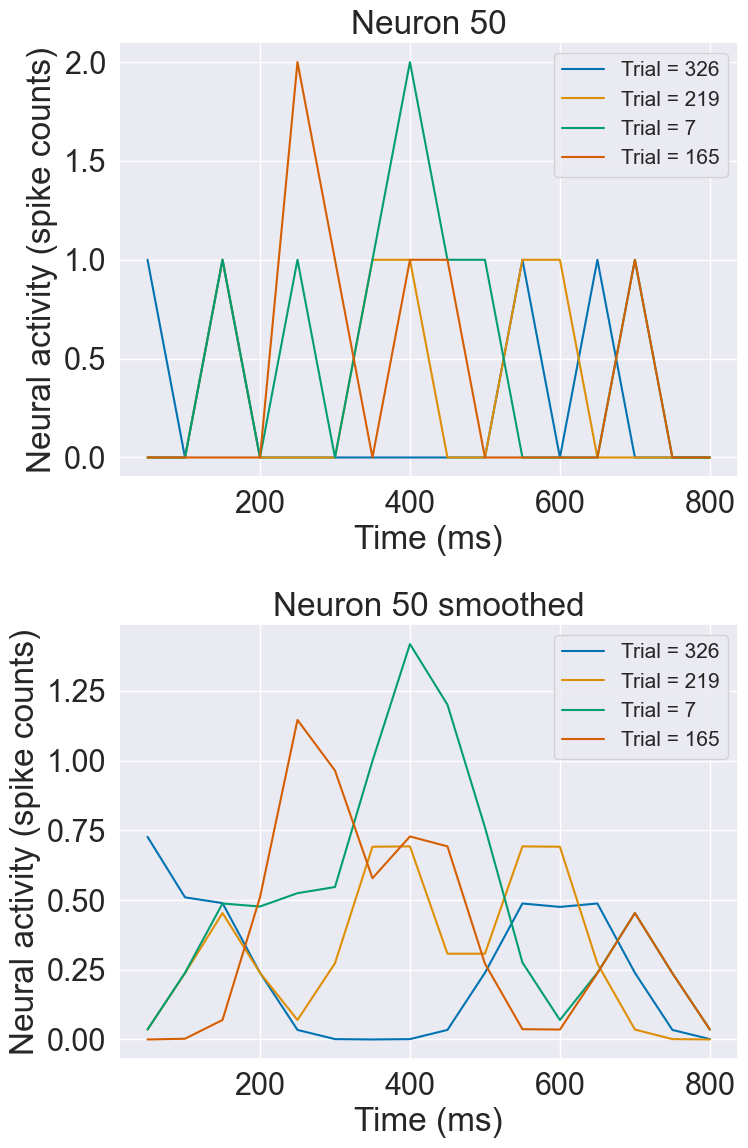

In [221]:
plot_psths(Neural_train, times, 2, 1, 4)
plt.savefig('Figures/Smoothing.png', format="png", dpi=800, bbox_inches="tight")

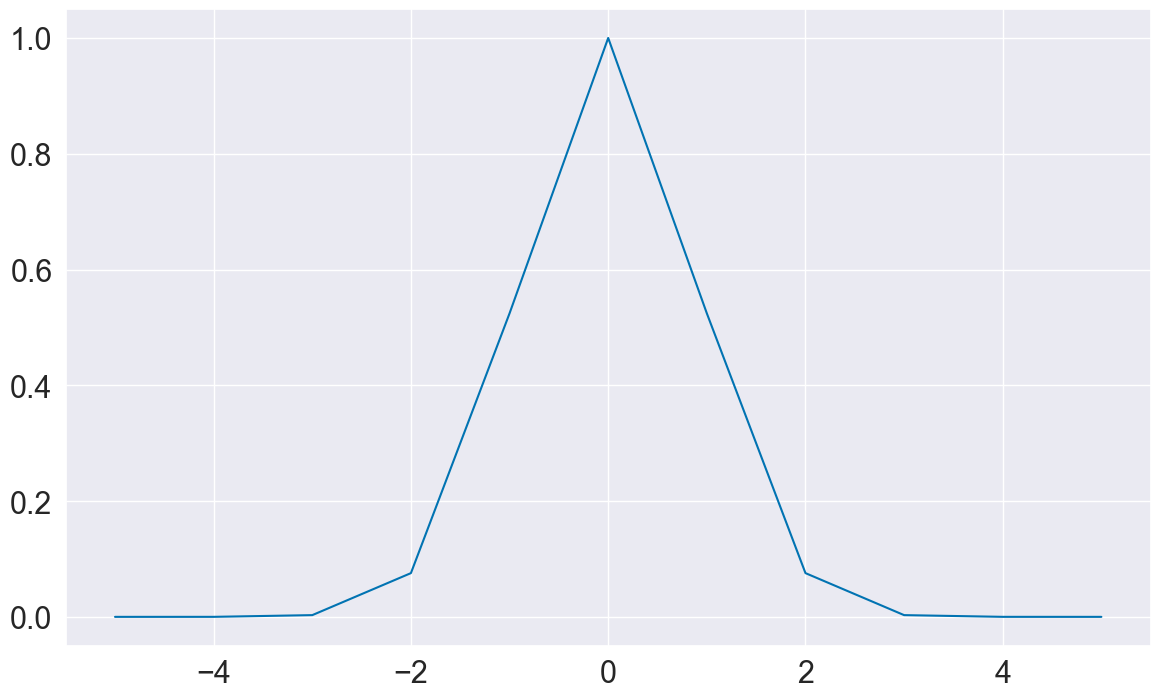

In [222]:
plt.plot(np.linspace(-5,5,11), scipy.signal.windows.gaussian(11, 0.88))
plt.savefig('Figures/gausskernel.png', format="png", dpi=800, bbox_inches="tight")
plt.show()
plt.close()

## Decoder

In [223]:
def W_MAP_calc(V, X_til, lam):
    lam_I_n = lam * np.identity(X_til.shape[0])
    brackets = inv(np.tensordot(X_til, X_til, axes=([1,2], [1,2])) + lam_I_n)
    return np.tensordot(V, X_til, axes=([1,2], [1,2])) @ brackets

## Test

In [224]:
for std in [0.88]:
    Neural_train_filt = smoother(Neural_train, std)
    Neural_test_filt = smoother(Neural_test, std)
    for lam in [0.01, 0.1, 1, 2.5, 5]:
        W_MAP = W_MAP_calc(Hand_train, Neural_train, lam)
        Predicted_vel = np.tensordot(W_MAP, Neural_test_filt, axes=([1], [0]))
        np.save('Results/Ex_2_Pred_Vel_lam' + str(lam) + '_std' + str(std) + '.npy', Predicted_vel)

print(Predicted_vel.shape)

(2, 100, 16)


In [225]:

start_time = timeit.default_timer()
Predicted_vel = np.tensordot(W_MAP, Neural_test_filt, axes=([1], [0]))
time = timeit.default_timer() - start_time
print(time* 1000)

0.6266999989748001


# 2.5 Wiener Filter

In [226]:
Neural_train.shape

(162, 400, 16)

In [227]:
lag = 8

In [228]:
X_train_lags = np.zeros((lag * 162, 400, 16 + 1 - lag))
for k in range(400):
    for t in range(16 + 1 - lag):
        for l in range(lag):
            X_train_lags[(l*162):((l+1)*162), k, t] = Neural_train[:, k, t + lag - l - 1]

In [229]:
Hand_train_wien = Hand_train[:, :, (lag - 1):16]

In [230]:
X_lagsTX_lags = np.tensordot(X_train_lags, X_train_lags, axes=([1, 2],[1, 2]))
W_wien = inv(X_lagsTX_lags) @ np.tensordot(X_train_lags, Hand_train_wien, axes=([1,2], [1,2]))

In [231]:
X_test_lags = np.zeros((lag * 162, 100, 16 + 1 - lag))
for k in range(100):
    for t in range(16 + 1 - lag):
        for l in range(lag):
            X_test_lags[(l*162):((l+1)*162), k, t] = Neural_test[:, k, t + lag - l - 1]

In [232]:
X_test_lags.shape

(1296, 100, 9)

In [233]:
start_time = timeit.default_timer()
V_predict = np.tensordot( W_wien, X_test_lags, axes=([0],[0]))
V_predict_concat = numpy.concatenate((Predicted_vel[:,:,0:(lag-1)], V_predict), axis=2)
time = timeit.default_timer() - start_time
print(time*1000)

2.638999998453073


In [234]:
V_predict_concat = numpy.concatenate((Predicted_vel[:,:,0:(lag-1)], V_predict), axis=2)
print(V_predict_concat.shape)
np.save('Results/Wien_Pred_Vel_lag' + str(lag) +  '.npy', V_predict_concat)

(2, 100, 16)


# 3. Kalman filter-based decoding

We now turn to a more sophisticated decoder based on a Kalman filter/smoother.

### 3.1 An autoregressive prior for hand kinematics

A 10-dimensional linear latent dynamical system (“LDS”; cf lecture notes) was pre-trained for you on the hand velocity data in the training set; specifically, we consider the following generative model:

$$
(1) \qquad z_{k, 0} \sim \mathcal{N}(\mu_0, \Sigma_0) \\ 
(2) \qquad z_{k, t+1} = A z_{k, t} + \epsilon_{k, t+1} \quad \text{with } \epsilon_{k, t+1} \sim \mathcal{N}(0, Q) \\
(3) \qquad v_{k, t} = C z_{k, t} + \eta_{k, t} \quad \text{with } \eta_{k, t} \sim \mathcal{N}(0, R)
$$

where $z_{k, t} \in \mathbb{R}^{10}$ is the latent state in time bin $t$ of trial $k$, and $v_{k, t} \in \mathbb{R}^2$ is the corresponding hand velocity. 

The parameters of this LDS can be found in the same `data` dictionary as above, with the following keys:
- "hand_KF_A" (`10 × 10`): state matrix $A$
- "hand_KF_C" (`2 × 10`): output matrix $C$
- "hand_KF_mu0" (`10 × 1`): initial prior mean $\mu_0$
- "hand_KF_Sigma0" (`10 × 10`): initial prior covariance $\Sigma_0$
- "hand_KF_Q" (`10 × 10`): process noise covariance matrix $Q$
- "hand_KF_R" (`2 × 2`): observation noise covariance matrix $R$

<u>Write your own Kalman smoother implementation and use it to compute the mean $\hat{z}_{k, 1:T}$ of the smoothing distribution $p(z_{k, t} | v_{k, 1:T})$, for each trial $k$ in the training set.</u>


In [235]:
z_0 = np.random.multivariate_normal(data['hand_KF_mu0'].reshape((-1,)), data['hand_KF_Sigma0'], size = (100,))

In [236]:
epsilon = np.random.multivariate_normal(np.zeros((10)), data['hand_KF_Q'], size = (100, 16))

In [237]:
A = data['hand_KF_A']
C = data['hand_KF_C']
R = data['hand_KF_R']
Q = data['hand_KF_Q']
Sigma0 = data['hand_KF_Sigma0']
mu0 = data['hand_KF_mu0'].reshape((10,))
v_train = data['hand_train']

Sigma_inv = np.zeros((10, 10, 400, 16))
mu = np.zeros((10, 400, 16))

CTRC = C.T @ inv(R) @ C
for i in range(Sigma_inv.shape[2]):
    P = inv(A @ Sigma0 @ A.T + Q)
    Sigma_inv[:, :, i, 0] = CTRC + P
    mu[:, i, 0] = inv(Sigma_inv[:, :, i, 0]) @ (P @ A @ mu0 + C.T @ inv(R) @ v_train[:, i, 0])
    for j in range(Sigma_inv.shape[3] - 1):
        P = inv(A @ inv(Sigma_inv[:, :, i, j]) @ A.T + Q)
        Sigma_inv[:, :, i, j + 1] = CTRC + inv(A @ inv(Sigma_inv[:, :, i, j]) @ A.T + Q)
        mu[:, i, j + 1] = inv(Sigma_inv[:, :, i, j + 1]) @ (P @ A @ mu[:, i, j] + C.T @ inv(R) @ v_train[:, i, j + 1])

In [238]:
Sigma_tilde = np.zeros((10, 10, 400, 16))
mu_tilde = np.zeros((10, 400, 16))

for i in range(Sigma_tilde.shape[2]):
    mu_tilde[:,: i, -1] = mu[:,: i, -1]
    Sigma_tilde[:,:, i, -1] = inv(Sigma_inv[:,:, i, -1])
    for j in range(Sigma_tilde.shape[3] - 1)[::-1]:
        Sigma_t = inv(Sigma_inv[:,:, i, j])
        P_t = A @ Sigma_t @ A.T + Q
        G_t = Sigma_t @ A.T @ inv(P_t)
        mu_tilde[:, i, j] = mu[:, i, j] + G_t @ (mu_tilde[:, i, j+1] - A @ mu[:, i, j])
        Sigma_tilde[:,:, i, j] = Sigma_t + G_t @ (Sigma_tilde[:,:, i, j+1] - P_t) @ G_t.T

### 3.2 Building an LDS model of neural data using supervised learning

Conceptually, the latents $z_{k, 1:T}$ introduced above contain signals related to the velocity of the hand, its acceleration, and potentially higher-order derivatives too — all signals which we have good reasons to suspect that neural activity in M1 is strongly related to. Eqs (1) and (2) above provide a good autoregressive prior model for the temporal dynamics of these signals, and you are now going to use this prior in a generative LDS model of _neural data_, substituting the hand-related likelihood (Eq 3) with a neural likelihood:

$$
(4) \qquad x_{k, t} = D z_{k, t} + \xi_{k, t} \quad \text{with } \xi_{k, t} \sim \mathcal{N}(0, S)
$$

where $x_{k, t}$ denotes neural spike counts in the $t^\text{th}$ time bin of trial $k$.

The combination of Eqs (1), (2) and (4) forms an LDS model which you will be able to invert using Kalman filtering to obtain a filtered posterior $p(z_{k', t} | x_{k', 0:t})$ for any test trial $k'$. From there, you will use Eq. (3) to obtain a filtered predictive distribution for the hand velocity in each test trial, $p(v_{k', t} | x_{k', 0:t})$.

- <u>Begin by centering the neural data (both training and testing sets) by removing, for each neuron, its mean activity across both trials and time in the training set.</u>
- <u>Fit the likelihood parameters $D$ and $S$ through supervised learning, by maximizing the joint log-likelihood $\log p(\hat{z}_{k, 1:T}, x_{k, 1:T})$ averaged over all trials in the training set, where $\hat{z}_{k,1:T}$ is the posterior mean you obtained in Section 3.1.</u>
To do this, write down the average joint log likelihood and **show that it is maximized by the following parameter settings**:
    - $ \displaystyle D^\star = \left(\sum_{k, t} x_{k, t} \hat{z}_{k, t}^\top \right) \left( \sum_{k, t} \hat{z}_{k, t} \hat{z}_{k, t}^\top \right)^{-1} $
    - $ \displaystyle S^\star = \frac{1}{KT} \left( \sum_{k, t} x_{k, t} x_{k, t}^\top - D^\star \sum_{k, t} \hat{z}_{k, t} x_{k, t}^\top \right) $ where $K$ is the number of trials in the training set. **Include your derivations in your report.**

In [239]:
def center_data(data):
    mean = data.mean(axis=(1,2))
    mean = mean.reshape(162, 1, 1)
    data_centered = data - mean
    return data_centered

In [240]:
neural_train_cent = center_data(data['neural_train'])
neural_test_cent = center_data(data['neural_test'])

In [241]:
D_opt = np.tensordot(neural_train_cent, mu_tilde, axes=([1,2], [1,2])) @ inv(np.tensordot(mu_tilde, mu_tilde, axes=([1,2], [1,2])))

In [242]:
S_opt = (np.tensordot(neural_train_cent, neural_train_cent, axes=([1,2], [1,2])) - D_opt @ np.tensordot(mu_tilde, neural_train_cent, axes=([1,2], [1,2])))/(400*16)

### 3.3 Using Kalman filtering to predict the hand velocity

- Based on the model obtained in Section 3.2, <u>write your own Kalman filter implementation and compute the filtered posterior $p(z_{k', t} | x_{k', 0:t}) $ for each trial $k'$ in the test set.</u> What we are really interested in is the mean $\bar{z}_{k', t}$ of this filtered posterior, as our best prediction of the momentary hand velocity $v_{k', t}$ is then given by $\hat{v}_{k', t} = C \bar{z}_{k', t}$.
- <u>Submit your predictions to https://4G10.cbl-cambridge.org, in the same format as described in Section 2. Please select "Kalman filtering" in the dropdown list. Once again, you will receive immediate feedback in the form of an $R^2$ coefficient.</u> **Include this result in your report, and discuss; in particular, why do you think these predictions are much better than those of Section 2?**
- As in Section 2, **comment on the suitability of this more sophisticated decoding strategy for online decoding of movement in a BCI context**.
- Finally, **what approach(es) would you suggest to improve decoding performance even further? Include a discussion of the tradeoffs that would arise with these alternative approaches.** (max 1 page in your report)

In [243]:
Sigma_inv_test = np.zeros((10, 10, 100, 16))
mu_test = np.zeros((10, 100, 16))

S_inv = inv(S_opt)
DTSD = D_opt.T @ S_inv @ D_opt
for i in range(Sigma_inv_test.shape[2]):
    P = inv(A @ Sigma0 @ A.T + Q)
    Sigma_inv_test[:, :, i, 0] = DTSD + P

    mu_test[:, i, 0] = inv(Sigma_inv_test[:, :, i, 0]) @ (P @ A @ mu0 + D_opt.T @ S_inv @ neural_test_cent[:, i, 0])
    for j in range(Sigma_inv_test.shape[3] - 1):
        if j == 14 and i == 99:
            start_time = timeit.default_timer()
        P = inv(A @ inv(Sigma_inv_test[:, :, i, j]) @ A.T + Q)
        Sigma_inv_test[:, :, i, j + 1] = DTSD + inv(A @ inv(Sigma_inv_test[:, :, i, j]) @ A.T + Q)
        mu_test[:, i, j + 1] = inv(Sigma_inv_test[:, :, i, j + 1]) @ (P @ A @ mu_test[:, i, j] + D_opt.T @ S_inv @ neural_test_cent[:, i, j + 1])
v_test = np.tensordot(C, mu_test, axes=([1],[0]))
time = timeit.default_timer() - start_time
print(time*1000)
np.save('Results/Ex_3_Pred_Vel.npy', v_test)

0.5658000009134412


# Writing up


Please write up your findings in a report to be submitted on Moodle in PDF format, and **include all your code in the Appendix**. Please clearly include your candidate number, NOT your name, on the front page. Your report should address all the questions raised in this notebook, be structured around the Sections of this notebook, and **be a maximum of five A4 pages** excluding any Appendix (minimum font size 11pt, minimum margins 1.5cm on each side).

You are very much encouraged to think of data/results visualisations to best support the exposition of your results. You are also encouraged to report on any specific problems/difficulties that arose in your implementation of the various algorithms, and how you addressed those.